<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/39/VU_logo.png/800px-VU_logo.png?20161029201021" width="350">

### Programming large-scale parallel systems

# Partial Differential Equations (PDEs)

## Contents

In this notebook, we will learn

- Key concepts for the solution of PDEs on large-scale computers
- What is a preconditioner
- What is a multi-grid solver
- Parallelization of conjugate gradient method
- Distributed sparse matrix-vector product

<div class="alert alert-block alert-info">
<b>Note:</b> Do not forget to execute the cell below before starting this notebook! 
</div>

In [1]:
using Printf
function answer_checker(answer,solution)
    if answer == solution
        "🥳 Well done! "
    else
        "It's not correct. Keep trying! 💪"
    end |> println
end
pdes_check_1(answer)=answer_checker(answer, "b")

pdes_check_1 (generic function with 1 method)

## Mini project

For the demonstration of different numberical methods we will use the example project of simulating the temperature distribution in a closed room. 

### Problem statement

Given the temperature at the boundary of a room, predict the temperature at any point in the room. The illustration below shows the temperature at different intervals of the room boundary (including a window and a heater). 

We will discuss the serial implementation first and learn how to compute it in parallel afterwards.

<div>
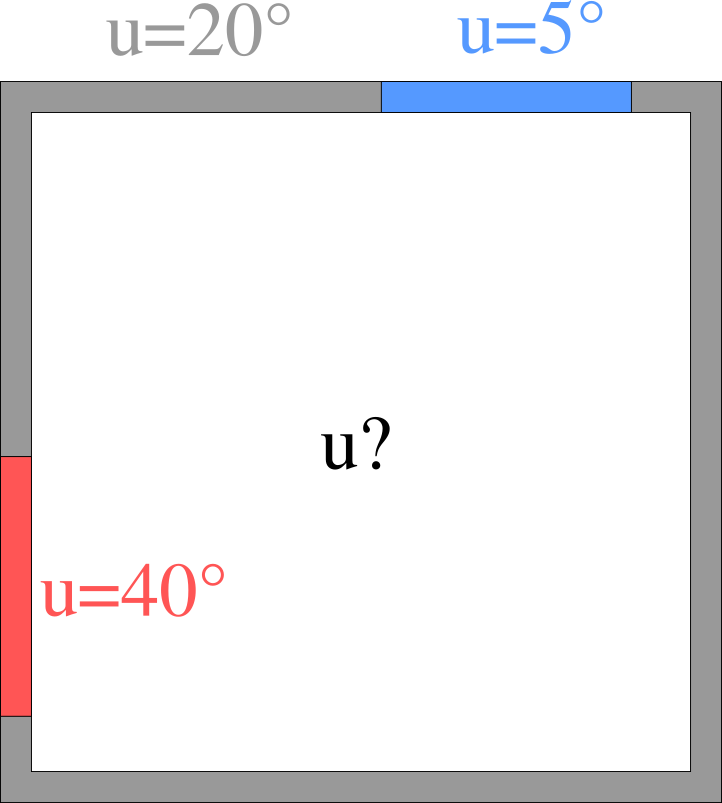
</div>


### Laplace equation

Assuming that the room is isolated, it can be shown that the temperature in the room can be described using the [Laplace equation](https://en.wikipedia.org/wiki/Laplace%27s_equation)


$$\dfrac{\partial^2 u(x,y)}{\partial x^2} + \dfrac{\partial^2 u(x,y)}{\partial y^2} = 0.$$


 Pierre-Simon, marquis de Laplace (1749-1827)
 
 *Picture from wikipedia*

<div>
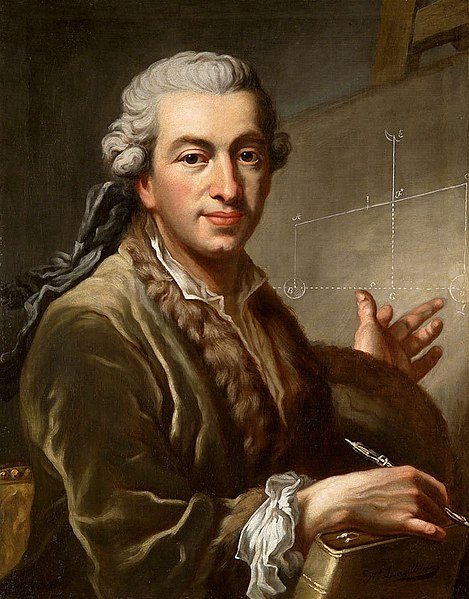
</div>

### Boundary value problem (BVP)

$\dfrac{\partial^2 u}{\partial x^2} + \dfrac{\partial^2 u}{\partial y^2} = 0 \text{ in the room}$

$u = 5 \text{ on the window}$

$u = 40 \text{ on the heater}$

$u = 20 \text{ on the walls}$


<div>
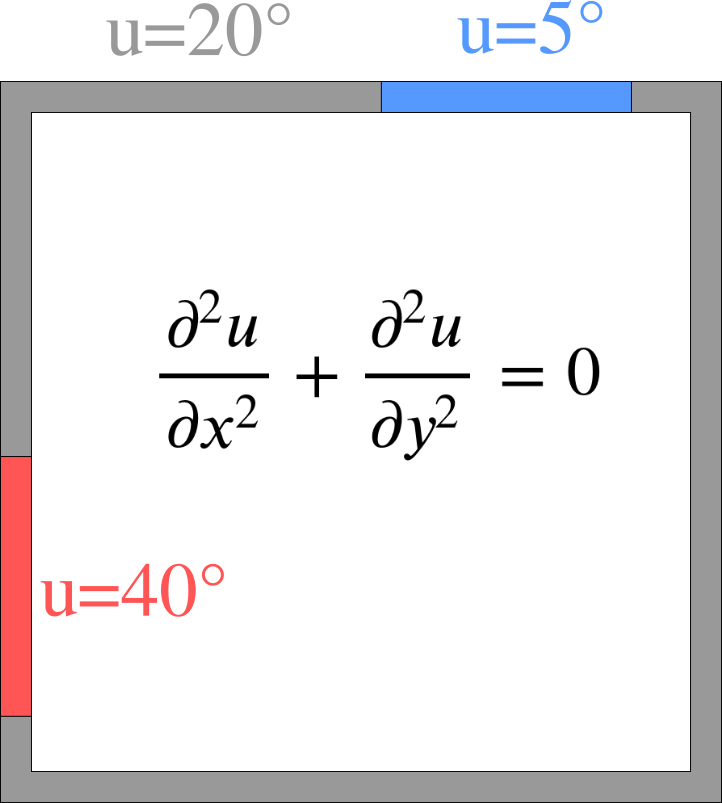
</div>

### Numerical methods for PDEs

There are several methods for solving PDEs: 

- Finite difference method (FDM)
- Finite element method (FEM)
- Finite volume method (FVM)
- Boundary element method (BEM)
- Meshfree methods

All of them follow the same main idea: to transform a PDE into a system of linear equations. The problem is first discretized into a computational mesh. The solution to the PDE at any point of the mesh is then given by the solution for vector x. 



<div>
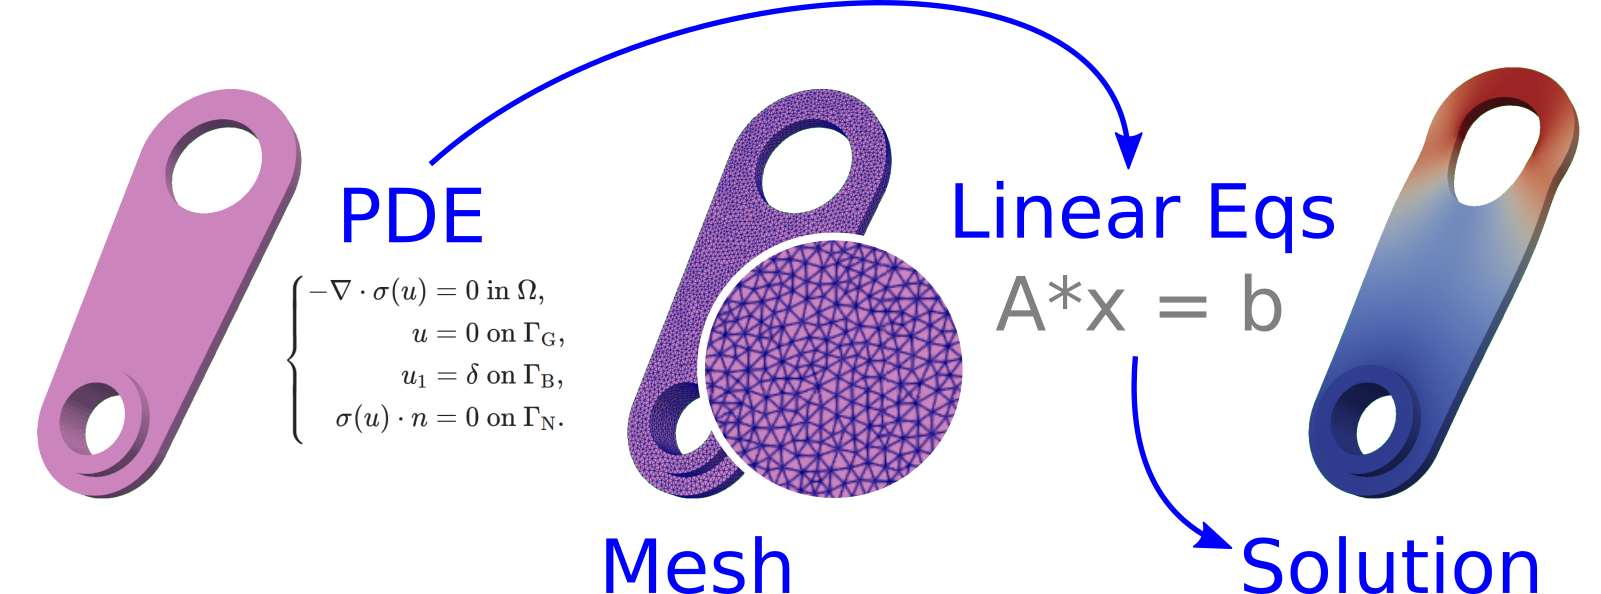
</div>

### Finite Difference method

To solve the temperature distribution in the room, we choose the Finite Difference method. The advantage of this method is that it is easy to implement and computationally efficient. On the other hand, it is not suitable for more complex geometries. 

<div>
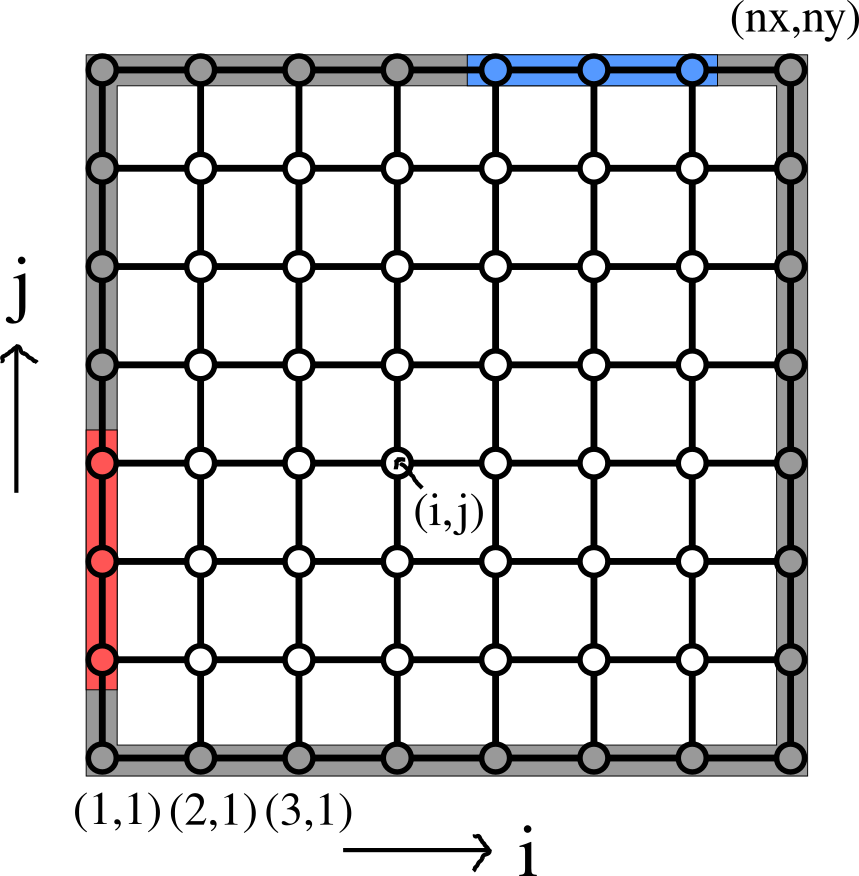
</div>


With the finite difference method, we first model the room as a grid, which can be stored using an array. Each entry of the matrix `u[i,j]` represents the temperature in the room at point $(i,j)$. The goal is now to compute the temperature at each grid point. 

Let's set up the grid matrix for our problem.

In [ ]:
] add Plots IterativeSolvers Preconditioners Printf SparseArrays LinearAlgebra

In [4]:
N = 8
u = zeros(N,N)

8×8 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [5]:
function fill_boundary!(u)
    u_window = 5.0
    u_heater = 40.0
    u_wall = 20.0
    window_span = (0.6,0.9)
    heater_span = (0.2,0.4)
    nx,ny = size(u)
    hx,hy = 1 ./ (nx-1,ny-1)
    for j in 1:ny
        y = hy*(j-1)
        for i in 1:nx
            x = hx*(i-1)
            if j==ny && (window_span[1]<=x && x<=window_span[2])
                u[i,j] = u_window
            elseif i==1 && (heater_span[1]<=y && y<=heater_span[2])
                u[i,j] = u_heater
            elseif (j==1||j==ny) || (i==1||i==ny)
                u[i,j] = u_wall
            end
        end
    end
    u
end

fill_boundary! (generic function with 1 method)

In [6]:
fill_boundary!(u)

8×8 Matrix{Float64}:
 20.0  20.0  40.0  20.0  20.0  20.0  20.0  20.0
 20.0   0.0   0.0   0.0   0.0   0.0   0.0  20.0
 20.0   0.0   0.0   0.0   0.0   0.0   0.0  20.0
 20.0   0.0   0.0   0.0   0.0   0.0   0.0  20.0
 20.0   0.0   0.0   0.0   0.0   0.0   0.0  20.0
 20.0   0.0   0.0   0.0   0.0   0.0   0.0   5.0
 20.0   0.0   0.0   0.0   0.0   0.0   0.0   5.0
 20.0  20.0  20.0  20.0  20.0  20.0  20.0  20.0

### Data Visualization

To illustrate the solution, we also write a visualization function that plots the temperature of the room as a heatmap. 

In [7]:
using Plots

In [8]:
function visualize(u;title="Temperature distribution")
    xlabel="x-coordinate"
    ylabel="y-coordinate"
    aspectratio = :equal
    plt = plot(;size= 1.5 .*(350,300),title,xlabel,ylabel,aspectratio,fontsize=100)
    nx,ny = size(u)
    hx,hy = (1,1) ./ (nx-1,ny-1)
    x = hx .* ((1:nx) .- 1)
    y = hy .* ((1:ny) .- 1)
    heatmap!(x,y,transpose(u),color=:thermal)
    plt
end

visualize (generic function with 1 method)

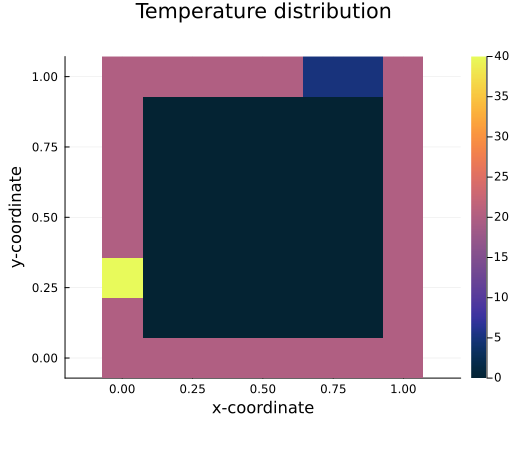

In [9]:
visualize(u)

### How to find the temperature at the interior points?

To set up a system of linear equations, we have to find one equation for each unknown value in the grid. The Laplace equation can be approximated by the following linear equation:

$$\dfrac{\partial^2 u}{\partial x^2} + \dfrac{\partial^2 u}{\partial y^2} = 0 $$

$$\downarrow$$

$$u_{i-1,j} + u_{i+1,j} + u_{i,j-1} + u_{i,j+1} - 4u_{i,j} = 0.$$

This approximation computes the value at point $(i,j)$ by combining the values of its neighbors. 



<div>
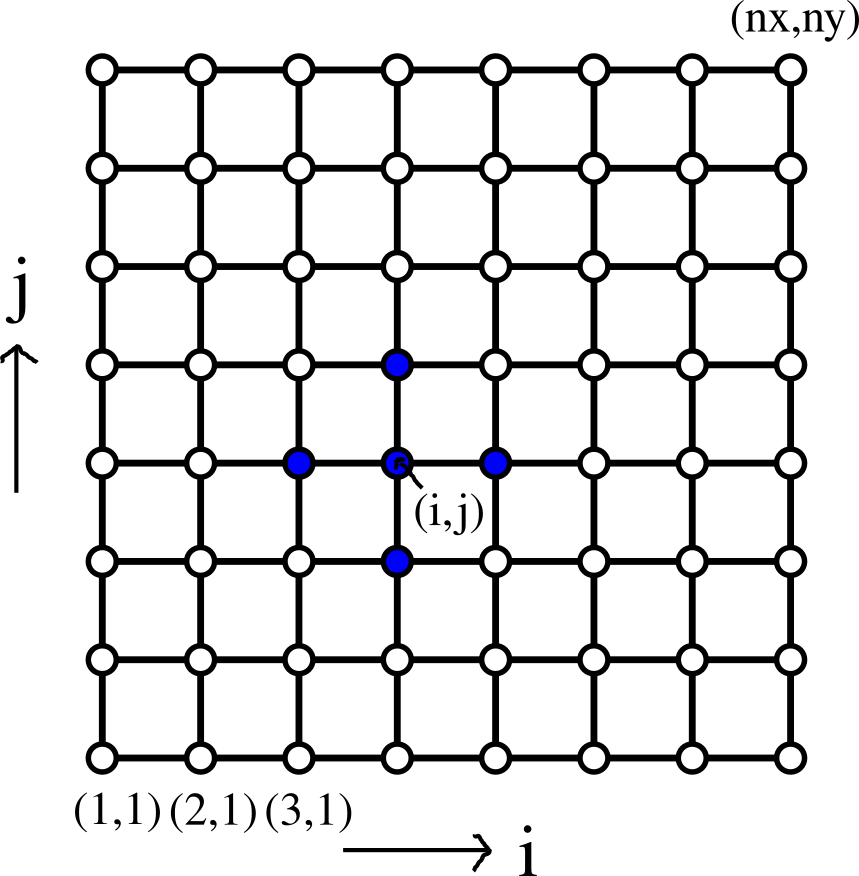
</div>


### System of linear equations
 
We can now obtain this kind of equation for every unknown point in the grid (= all the interior points). All these equations can be arranged in array form
 
$$Ax=b.$$

Next we create the matrix $A$: 

In [10]:
using SparseArrays
function generate_system_sparse(u)
    nx,ny = size(u)
    stencil = [(-1,0),(1,0),(0,-1),(0,1)]
    nnz_bound = 5*nx*ny
    nrows = (nx-2)*(ny-2)
    ncols = nrows
    b = zeros(nrows)
    I = zeros(Int,nnz_bound)
    J = zeros(Int,nnz_bound)
    V = zeros(nnz_bound)
    inz = 0
    for j in 2:(ny-1)
        for i in 2:(nx-1)
            row = i-1 + (ny-2)*(j-2)
            inz += 1
            I[inz] = row
            J[inz] = row
            V[inz] = 4.0
            for (di,dj) in stencil
                on_boundary = i+di in (1,nx) || j+dj in (1,ny)
                if on_boundary
                    b[row] += u[i+di,j+dj]
                    continue
                end
                col = i+di-1 + (ny-2)*(j+dj-2)
                inz += 1
                I[inz] = row
                J[inz] = col
                V[inz] = -1.0
            end
        end
    end
    A = sparse(view(I,1:inz),view(J,1:inz),view(V,1:inz),nrows,ncols)
    A,b
end

generate_system_sparse (generic function with 1 method)

In [11]:
N = 5
u = zeros(N,N)
A, b = generate_system_sparse(u)
A

9×9 SparseMatrixCSC{Float64, Int64} with 33 stored entries:
  4.0  -1.0    ⋅   -1.0    ⋅     ⋅     ⋅     ⋅     ⋅ 
 -1.0   4.0  -1.0    ⋅   -1.0    ⋅     ⋅     ⋅     ⋅ 
   ⋅   -1.0   4.0    ⋅     ⋅   -1.0    ⋅     ⋅     ⋅ 
 -1.0    ⋅     ⋅    4.0  -1.0    ⋅   -1.0    ⋅     ⋅ 
   ⋅   -1.0    ⋅   -1.0   4.0  -1.0    ⋅   -1.0    ⋅ 
   ⋅     ⋅   -1.0    ⋅   -1.0   4.0    ⋅     ⋅   -1.0
   ⋅     ⋅     ⋅   -1.0    ⋅     ⋅    4.0  -1.0    ⋅ 
   ⋅     ⋅     ⋅     ⋅   -1.0    ⋅   -1.0   4.0  -1.0
   ⋅     ⋅     ⋅     ⋅     ⋅   -1.0    ⋅   -1.0   4.0

We created the matrix $A$ of the system of linear equations $Ax=b$ for a grid size $N=5$. For a grid of this size, we need 9 linear equations since there are 9 interior points. Note that we are using two types of numeration: one that defines the coordinates in the grid, e.g. $(2,3)$. The other numeration simply enumerates the interior values row-wise (1,2,...,9). The latter numeration is used to construct the matrix $A$. 

For any grid size, the equations matrix will only contain up to 5 nonzero values per row. Therefore, it is useful to store it as a sparse array which only stores the nonzero values under the hood. This is essential for the implementation because a lot of memory can be saved in this way. 

$u_{i-1,j} + u_{i+1,j} + u_{i,j-1} + u_{i,j+1} - 4u_{i,j} = 0$

<div>
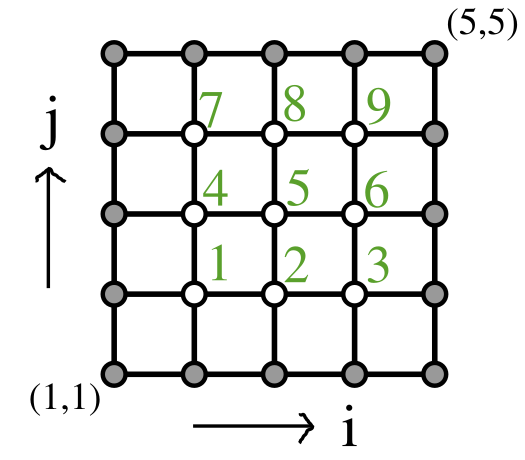
</div>

### Solution methods

Two possible solution methods have already been discussed in the course:

- Jacobi method
- Gaussian elimination

To determine wether any of these methods are useful solvers for our problem, we analyze if they are _algorithmically scalable_. 

### Algorithmically scalable solver

A computation method is an _algorithmically scalable_ solver if the total cost scales at most linearly with respect to the total problem size.

<div class="alert alert-block alert-success">
<b>Question:</b>  Let $R$ be our problem size, the number of rows in our matrix $A$. Because we have $N$ points in each dimension of the grid, $R=O(N^2)$. What is the complexity of the Jacobi method and Gaussian elimination with respect to the problem size $R$?
</div>

    a) Jacobi: O(N^2) = O(R) per iteration, GE: O(N^3) = O(R*sqrt(R))
    b) Jacobi: O(N^2) = O(R) per iteration, GE: O(R^3)
    c) Jacobi: O(R^2) per iteration, GE: O(R^3)
    d) Jacobi: O(N^2) = O(R) per iteration, GE: O(R) 

In [12]:
answer="x" # Replace x with a,b,c or d
pdes_check_1(answer)

It's not correct. Keep trying! 💪


To conclude, we find that none of the two solvers are algorithmically scalable. The Jacobi method scales linearly with respect to the problem size per iteration. However, the number of iterations might increase with the problem size, as we will demonstrate in the next section.

### Complexity of Jacobi method

Next we implement the Jacobi method to solve the PDE. In addition to using a fixed maximum number of iterations, we introduce a relative tolerance threshold. The iterations stop when the relative error in an iteration subceeds this threshold.

In [13]:
using LinearAlgebra
function jacobi!(u,f=zeros(size(u));reltol=0.0,maxiters=0)
    u_new = copy(u)
    e = similar(u)
    ni,nj = size(u)
    for iter in 1:maxiters
        for j in 2:(nj-1)
            for i in 2:(ni-1)
                u_new[i,j] =
                  0.25*(u[i-1,j] + u[i+1,j] + u[i,j-1] + u[i,j+1] + f[i,j])
            end
        end
        e .= u_new .- u
        relerror = norm(e)/norm(u_new)
        if relerror < reltol
            return u_new, iter
        end
        u, u_new = u_new, u
    end
    u, maxiters
end

jacobi! (generic function with 2 methods)

Run the following code cell several times with different values for $N$. For instance, $N=10$, $N=20$, $N=40$. Compare the number of iterations that are needed to converge for each problem size.

Jacobi converged in 136 iterations


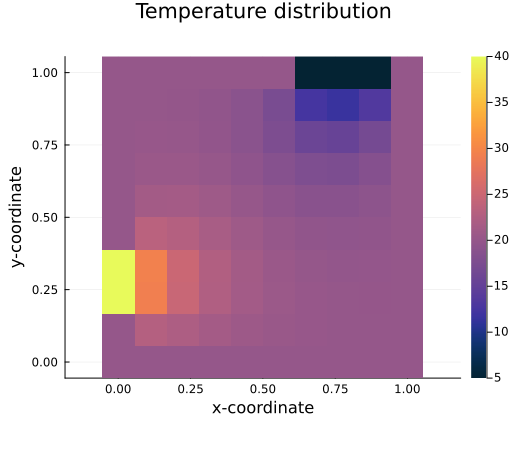

In [14]:
N = 10
u = zeros(N,N)
fill_boundary!(u)
u, iter = jacobi!(u,reltol=1.0e-5,maxiters=1000000)
println("Jacobi converged in $iter iterations")
visualize(u)

### Convergence analysis
We can observe that the number of iterations scales with the problem size. In the next step, we plot the number of iterations needed for convergence against the problem size. 

In [15]:
plt = plot(xlabel="N^2",ylabel="Iterations");

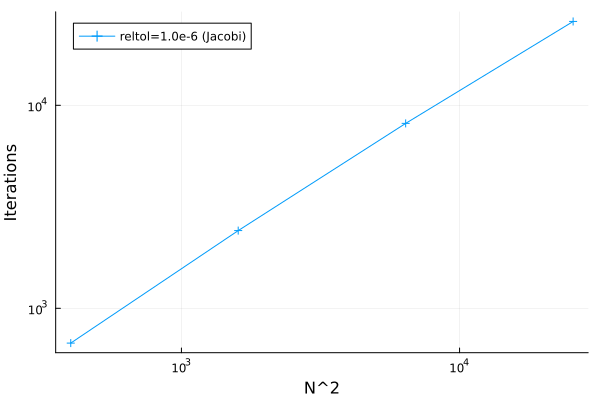

In [16]:
Ns = [20,40,80,160]
reltol = 1.0e-6
iters = zeros(size(Ns))
for (i,N) in enumerate(Ns)
    u = zeros(N,N)
    fill_boundary!(u)
    u, iter = jacobi!(u;reltol=reltol,maxiters=1000000)
    iters[i] = iter
end
plot!(plt,Ns.^2,iters,xaxis=:log10,yaxis=:log10,label="reltol=$reltol (Jacobi)",marker=:auto)
plt

It can be analytically proven that the number of iterations to achieve a relative error of $10^{-s}$ increases as $O(s N^2)$. Remember: The cost per iteration of the Jacobi method is $O(N^2) = O(R)$. Treating $s$ as a constant, the total cost of the Jacobi method will be $O((N^2)^2) = O(R^2) = O(N^4)$.


### Complexity of some solvers

There exist several methods to solve a Laplace equation on a regular mesh of $S$ points ($S=N^d$). The following table compares the scalability of these solvers for different numbers of mesh dimensions.

| Solver | 1D | 2D | 3D |
|--|--|--|--|
| Dense Cholesky | O(S^3) | O(S^3) | O(S^3) |
| Sparse Cholesky | O(S) | O(S^1.5) | O(S^2) |
| Conjugate gradient + Multi grid | O(S) | O(S) | O(S) |


## Conjugate gradient method

In this section, we will discuss the [Conjugate Gradient Method](https://en.wikipedia.org/wiki/Conjugate_gradient_method). Combined with the multi grid method, it achieves the best scalability for solving Laplace equations.


The idea of the conjugate gradient method is to transform the problem into an optimization problem of the form

$$ x = \text{arg }\min_{y} f(y)$$ 

<p style="text-align:center">with</p> 

$$ f(y)= \frac{1}{2}( y^\mathrm{T}Ay - y^\mathrm{T} b ).$$

Thus, the goal is to find vector $x$, the minimum of function $f(y)$. This vector is equivalent to the solution of the system of linear equations, $A x = b$.  

The conjugate gradient method is a gradient descent algorithm optimized for symmetic ($A^\mathrm{T}=A$) positive-definite ($y^\mathrm{T}Ay > 0$) matrices. The algorithm is applicable to our problem since the matrix $A$ is both symmetric and positive-definite.


### Top 10 algorithms of the 20th century

The conjugate gradient method is a type of Krylov subspace method, which is listed by the IEEE Computer Society as one of the top 10 algorithms of the past century:

- Metropolis Algorithm for Monte Carlo
- Simplex Method for Linear Programming
- **Krylov Subspace Iteration Methods**
- The Decompositional Approach to Matrix Computations
- The Fortran Optimizing Compiler
- QR Algorithm for Computing Eigenvalues
- Quicksort Algorithm for Sorting
- Fast Fourier Transform
- Integer Relation Detection
- Fast Multipole Method



### Convergence analysis

For the following convergence analysis, we will use the implementation of the conjugate gradient method from the `IterativeSolvers` package.

Converged after 158 iterations.

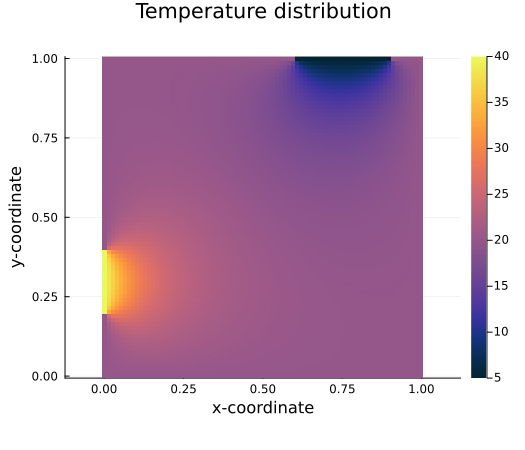

In [17]:
using IterativeSolvers: cg!
N = 80
u = zeros(N,N)
fill_boundary!(u)
A,b = generate_system_sparse(u)
x = zeros(length(b))
_,ch = cg!(x, A, b, reltol=1e-5,log=true)
display(ch)
u[2:end-1,2:end-1] = x
visualize(u)

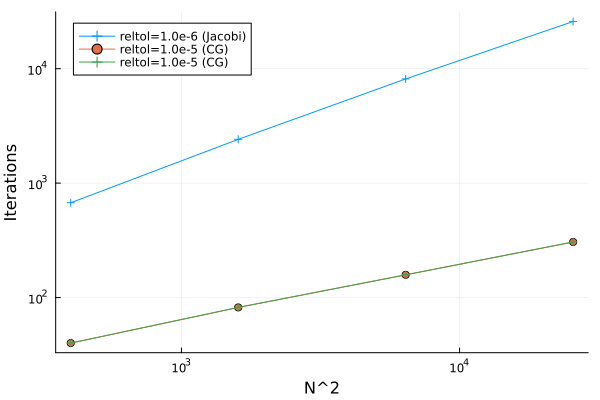

In [19]:
Ns = [20,40,80,160]
reltol = 1.0e-5
iters = zeros(size(Ns))
for (i,N) in enumerate(Ns)
    u = zeros(N,N)
    fill_boundary!(u)
    A,b = generate_system_sparse(u)
    x = zeros(length(b))
    _,ch = cg!(x, A, b, reltol=reltol,log=true)
    iters[i] = ch.iters
end
plot!(plt,Ns.^2,iters,xaxis=:log10,yaxis=:log10,label="reltol=$reltol (CG)",marker=:auto)
plt

The number of iterations needed to converge is much lower with the conjugate gradient method than with the Jacobi method. However, the number of iterations still increase with the problem size, so there is still room for improvement. 

### Number of iterations

We can prove that the number of iterations to achieve a relative error of $10^{-s}$ increases as $O(s \sqrt{\kappa(A)})$. As a reminder, the condition number of A $\kappa(A)$ is ratio between the largest and smallest eigenvalues of A: 
$$\kappa(A)=\dfrac{\lambda_{max}(A)}{\lambda_{min}(A)}$$

It can be shown that in our example $\kappa(A) = O(N^2)$. Thus, the number of iterations scales as $O(s N)$ for the conjugate gradient method. Remember that the number of iterations scales as $O(sN^2)$ for the Jacobi method.


### Goal

The conjugate gradient method provides some improvement to the Jacobi method, since the number of iterations increases more slowly with the problem size. However, the ultimate goal is to find an iterative method whose number of iterations is _independent_ of the problem size.

### Preconditioner

To achieve this goal, we will apply a [preconditioner](https://en.wikipedia.org/wiki/Preconditioner) to transform the original problem into a format that is easier to solve. 

A preconditioner is simply a linear function $M$ such that 
$$M(b) \approx x, \text{ with } Ax=b \text{ for any }  b.$$ 

When we have found such a function $M(b)$, we can solve the _preconditioned problem_ $(MA)x = Mb$, which is equivalent to $Ax=b$.

The way that this preconditioning affects the number of iterations is that it reduces the condition number of $A$: 

$$ \begin{align}
&M(b) \approx x, \text{ with } Ax=b \text{ for any }  b \\
&\rightarrow M(b) \approx A^{-1}b \\
&\rightarrow M \approx A^{-1} \\
&\rightarrow M A \approx I \text{ (Identity matrix)} \\
&\rightarrow \kappa (MA) \approx 1 \\
\end{align}$$

We mentioned that the number of iterations to achieve a relative error of $10^{-s}$ is $O(s\sqrt{\kappa (A)})$. With $\kappa (MA) \approx 1$, the number of iterations will scale as $O(s)$. Thus, the number of iterations will be independent of the problem size for the preconditioned problem. 




### How to build a preconditioner  ?

Many ways of building a preconditioner can be found in the literature. The solutions range between two extremes: 

1. $M=A^{-1}$. This is the exact preconditioner. The CG method will converge in just one iteration. However, it is exactly as costly to compute the matrix $M$ as it is to find the solution to the original problem. 
2. $M=I$. This is the other extreme where we do no extra work to find the matrix $M$. The preconditioned problem is identical to the original problem.

The solution is to find a good trade-off such that we get a matrix $M$ that is accurate enough to approximate the original problem but also cheap enough to be computed quickly. 

### Jacobi Preconditioner

Next we use the Jacobi method to construct a preconditioner for the CG method. The matrix $M$ is simply computed as the grid values after a certain number of iterations with the Jacobi method. In order for $M$ to be linear, we set a fixed maximum number of iterations in the `jacobi!` function and disable the relative error stopping criterion.

In [20]:
struct JacobiPrec{T}
    u::Matrix{T}
    f::Matrix{T}
    niters::Int
end
function jacobi_prec(N;niters)
    u = zeros(N,N)
    f = zeros(N,N)
    JacobiPrec(u,f,niters)
end
function LinearAlgebra.ldiv!(x,M::JacobiPrec,b)
    M.u[2:end-1,2:end-1] .= 0 
    M.f[2:end-1,2:end-1] = b
    u,_ = jacobi!(M.u,M.f,reltol=0,maxiters=M.niters)
    x[:] = @view u[2:end-1,2:end-1]
    x
end

Run the following cell for different values of `niters`. The larger the value of `niters`, the more matrix $M$ resembles the exact solution. The fewer iterations we use, the less accurate the approximation.

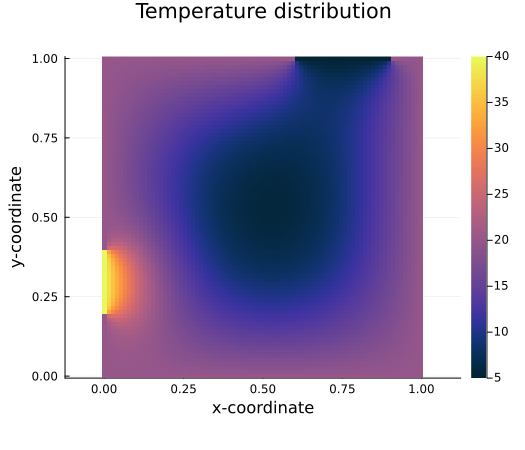

In [32]:
N = 80
u = zeros(N,N)
fill_boundary!(u)
A,b = generate_system_sparse(u)
# Generate preconditioner
M = jacobi_prec(N,niters=1000)
x = zeros(size(b))
# Compute solution as x=b/M
ldiv!(x,M,b)
u[2:end-1,2:end-1] = x
visualize(u)

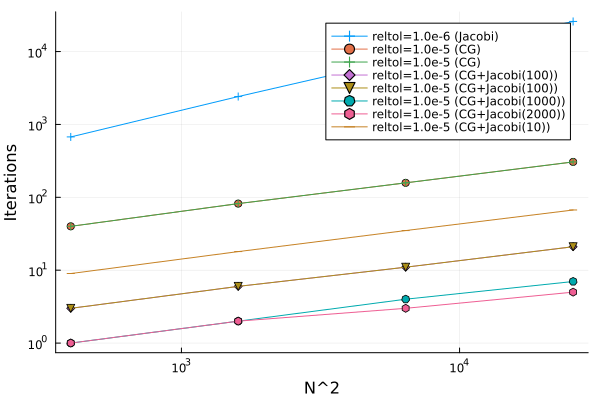

In [35]:
Ns = [20,40,80,160]
reltol = 1.0e-5
iters = zeros(size(Ns))
for (i,N) in enumerate(Ns)
    u = zeros(N,N)
    fill_boundary!(u)
    A,b = generate_system_sparse(u)
    M = jacobi_prec(N,niters=100)
    x = zeros(length(b))
    # Provide preconditioner to conjugate gradient method
    _,ch = cg!(x, A, b, Pl=M, reltol=reltol,log=true)
    iters[i] = ch.iters
end
plot!(plt,Ns.^2,iters,xaxis=:log10,yaxis=:log10,label="reltol=$reltol (CG+Jacobi($(M.niters)))",marker=:auto)
plt

Observe that the Jacobi preconditioner achieves that the CG method needs fewer iterations. However, the number of iterations still increases with the problem size. 

### How can we improve the Jacobi method?

We can optimize the Jacobi method to obtain a better preconditioner for the CG method. Run the following code cell again with a grid size of $N=10$ and $N=100$. 

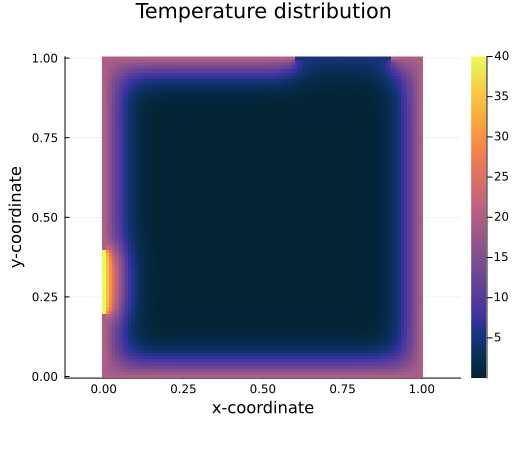

In [38]:
N = 100
u = zeros(N,N)
fill_boundary!(u)
A,b = generate_system_sparse(u)
M = jacobi_prec(N,niters=80)
x = zeros(size(b))
ldiv!(x,M,b)
u[2:end-1,2:end-1] = x
visualize(u)

The main reason that the preconditioner performs badly for larger problem sizes is that it takes more time to update the interior values of the grid. The larger the grid, the longer the Jacobi method needs to propagate the values from the outer boundary to the interior of the grid. 

### Multi-grid method

The [multi-grid method](https://en.wikipedia.org/wiki/Multigrid_method) is the second building block of the fast solver for our Laplace equation. 

The multi-grid method achieves a faster convergence of the Jacobi method by starting to solve the coarse problem first and then stepwise increasing the grid resolution. On each resolution level, a few steps of the Jacobi method are performed (only 2 steps per level in this example). Next, the resolution of the grid is increased and the Jacobi method is run again. This process is repeated until we reach the desired grid size. Since the Jacobi method converges after a few iterations on very small grids, the values are propagated to the center much more quickly than without using the multi-grid method.

In [39]:
function prolongate!(u_fine,u_coarse)
    ni_coarse, nj_coarse = size(u_coarse)
    ni_fine, nj_fine = size(u_fine)
    @assert 2*(ni_coarse-1) == (ni_fine-1)
    for j_fine in 1:nj_fine
        j_coarse = div(j_fine-1,2)+1
        j_rem = mod(j_fine-1,2)
        for i_fine in 1:ni_fine
            i_coarse = div(i_fine-1,2)+1
            i_rem = mod(i_fine-1,2)
            u_fine[i_fine,j_fine] = 0.25*(
                u_coarse[i_coarse,j_coarse] +
                u_coarse[i_coarse+i_rem,j_coarse] +
                u_coarse[i_coarse,j_coarse+j_rem] +
                u_coarse[i_coarse+i_rem,j_coarse+j_rem] )
        end
    end
end

prolongate! (generic function with 1 method)

[ Info: Saved animation to C:\Users\gelie\Home\TeachingInnovationProject\XM_40017\notebooks\a2.gif


Plots.AnimatedGif("C:\\Users\\gelie\\Home\\TeachingInnovationProject\\XM_40017\\notebooks\\a2.gif")
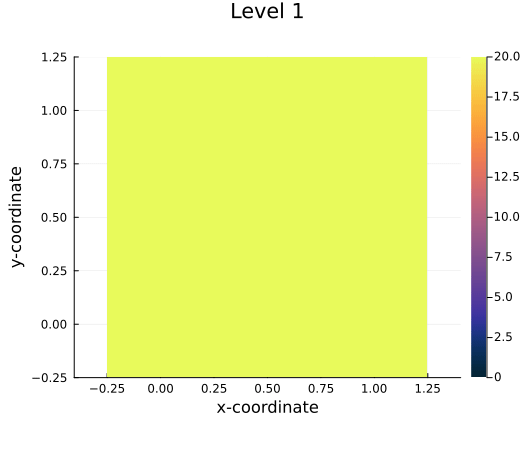

In [40]:
iters_in_level = [2,2,2,2,2,2,2,2]
u_coarse = zeros(2,2)
anim = @animate  for (level,iters) in enumerate(iters_in_level)
    N = 2^level
    u = zeros(1+N,1+N)
    prolongate!(u,u_coarse)
    fill_boundary!(u)
    global u_coarse
    u_coarse,_ = jacobi!(u,reltol=0,maxiters=iters)
    visualize(u,title="Level $level")
end
gif(anim,"a2.gif",fps=1)

### Multi-grid preconditioner

Let's see what happens when we use the CG method in combination with a multi-grid preconditioner. In the following code cell, we use a multi-grid preconditioner from the package `Preconditioners`.

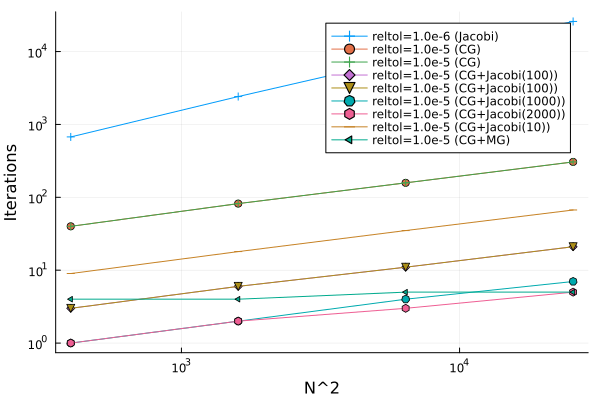

In [41]:
using Preconditioners
Ns = [20,40,80,160]
reltol = 1.0e-5
iters = zeros(size(Ns))
for (i,N) in enumerate(Ns)
    u = zeros(N,N)
    fill_boundary!(u)
    A,b = generate_system_sparse(u)
    M = AMGPreconditioner{SmoothedAggregation}(A)
    x = zeros(length(b))
    _,ch = cg!(x, A, b, Pl=M, reltol=reltol,log=true)
    iters[i] = ch.iters
end
plot!(plt,Ns.^2,iters,xaxis=:log10,yaxis=:log10,label="reltol=$reltol (CG+MG)",marker=:auto)
plt

The number of iterations is now constant for different problem sizes. Thus, we have finally achieved to build an algorithmically scalable solver by combining the conjugate gradient method and the multi-grid method!

### High-performance conjugate gradient (HPCG) benchmark

- Alternative to HPL benchmark to rank the [top 500](https://www.top500.org/) computers


Fig. from DOI: [10.1177/1094342015593158](https://journals.sagepub.com/doi/10.1177/1094342015593158)
<div>
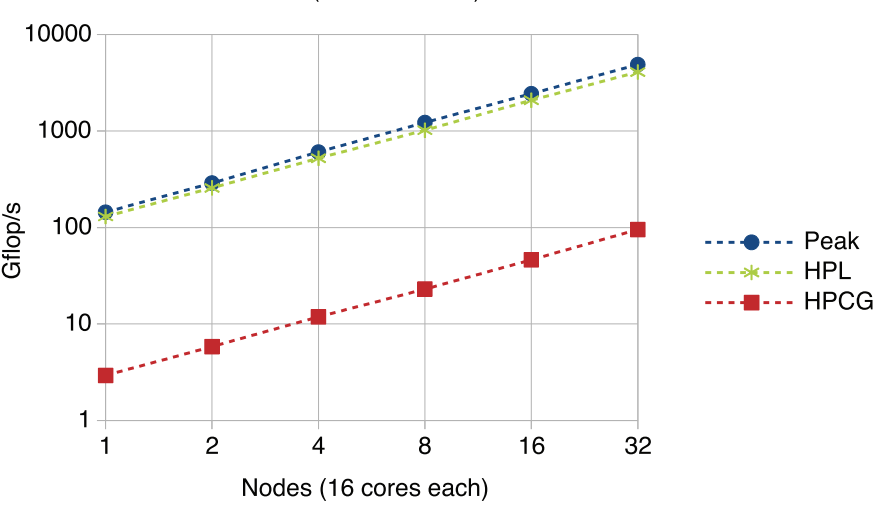
</div>

## Parallel implementation

### Conjugate gradient method

In [22]:
function conjugate_gradient!(x,A,b;M,reltol,maxiters=size(A,1))
    c = similar(x)
    u = similar(x)
    r = similar(x)
    mul!(c,A,x)
    r .= b .- c
    norm_r0 = sqrt(dot(r,r))
    for iter in 1:maxiters
        ldiv!(c,M,r)
        ρ_prev = ρ
        ρ = dot(c,r)
        β = ρ / ρ_prev
        u .= c .+ β .* u
        mul!(c, A, u)
        α = ρ / dot(u,c)
        x .= x .+ α .* u
        r .= r .- α .* c
        if sqrt(dot(r,r)) < reltol*norm_r0
            break
        end
    end
    x
end

conjugate_gradient! (generic function with 1 method)

The phases that are not trivially parallel are

- Dot products
- Sparse matrix-vector products
- Preconditioners

### Dot product


$\text{dot}(a,b)=  \sum_i a_i b_i$


<div>
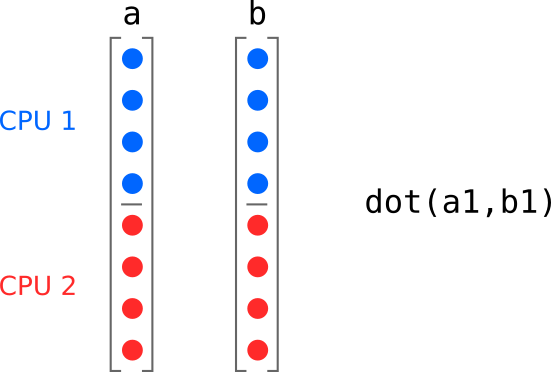
</div>

### MPI implementation

<div>
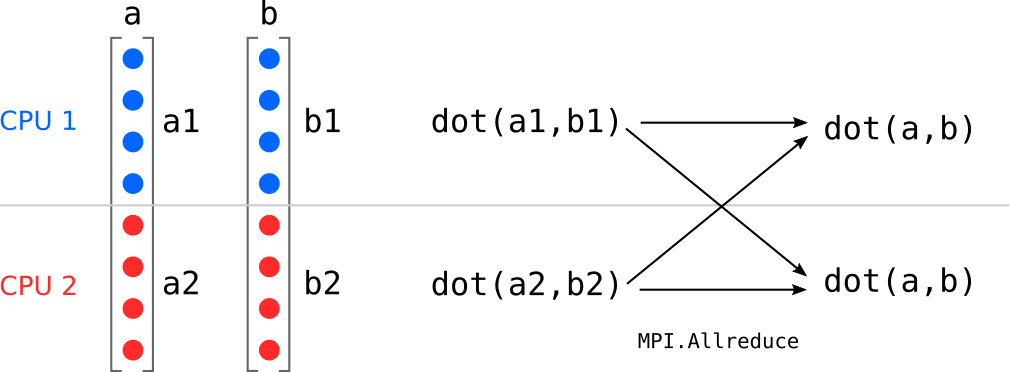
</div>


### Sparse matrix-vector product



<div>
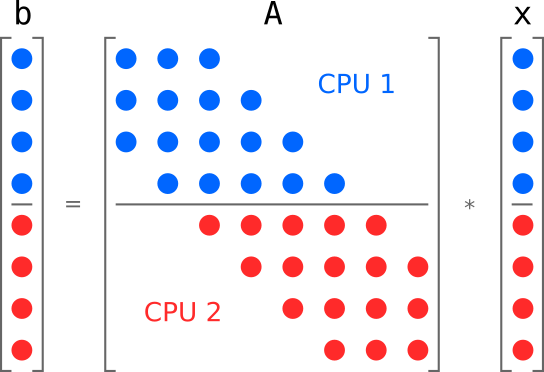
</div>


<div class="alert alert-block alert-success">
<b>Question:</b>  Which parts of $A$ and $x$ are needed to compute the local values of $b$ in a worker? 
</div>


- Answer: Only the entries of x associated with the non-zero columns of A stored in the worker.

### Ghost (halo) columns

<div>
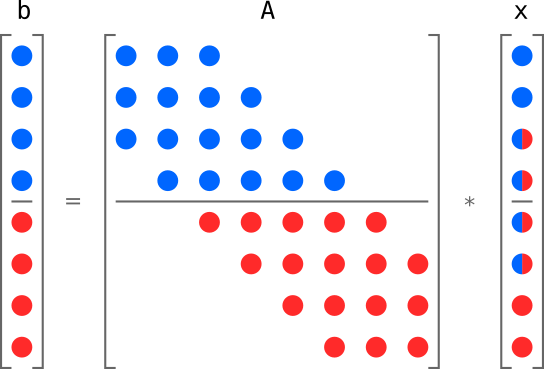
</div>

### Latency hiding

A = A_own + A_ghost



<div>
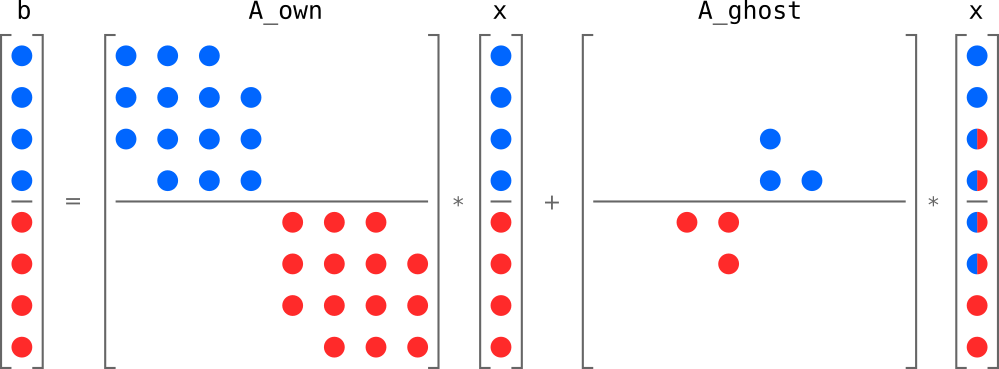
</div>

### Mesh partition

<div class="alert alert-block alert-success">
<b>Question:</b>  Which mesh partition does lead to less communication in the sparse matrix-vector product?
</div>

- Answer: 2d block (as for Jacobi method)


<div>
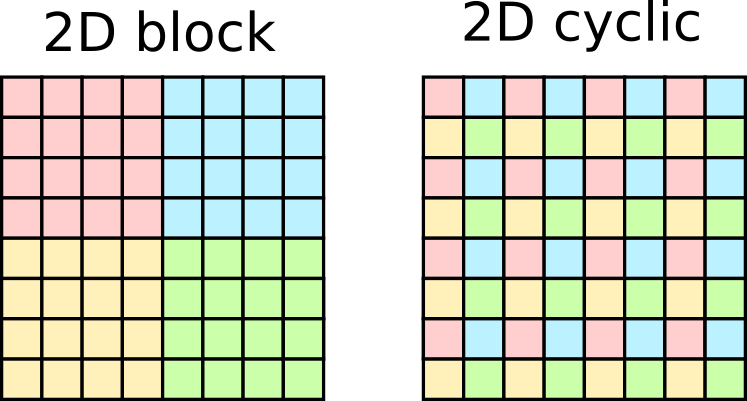
</div>

Remember:  The equation associated with point (i,j) is:

$u_{i-1,j} + u_{i+1,j} + u_{i,j-1} + u_{i,j+1} - 4u_{i,j} = 0$


<div>
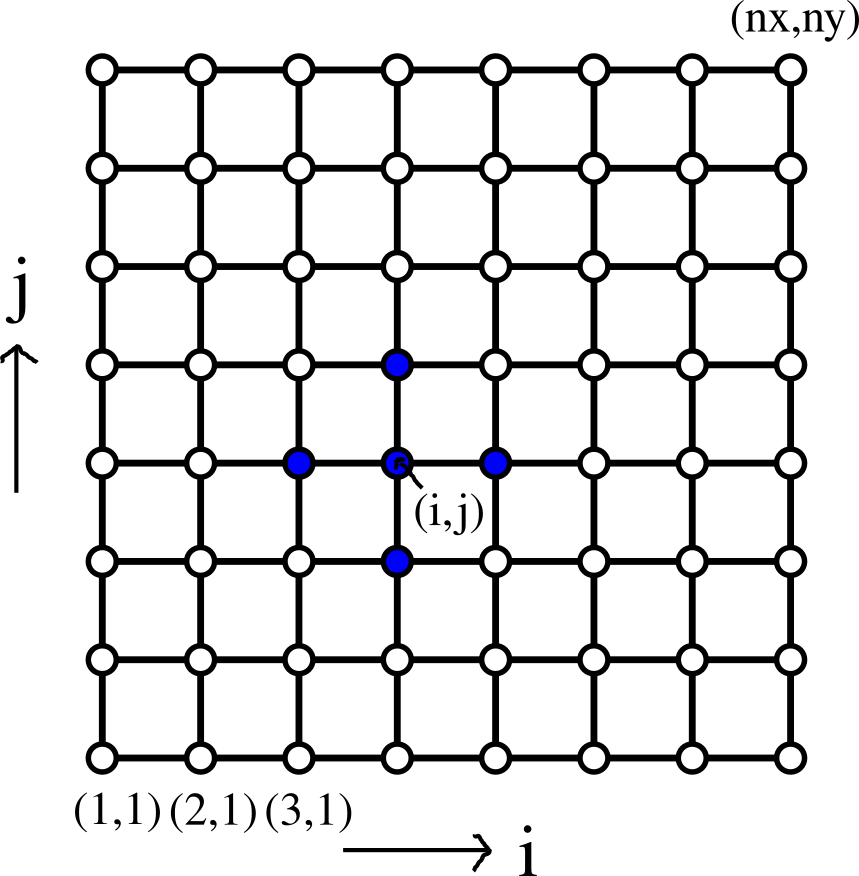
</div>


## How to partition unstructured meshes?

- FEM methods work on unstructured meshes
- One equation per node
- Non-zero columns are associated with nodes connected by mesh edges



<div>
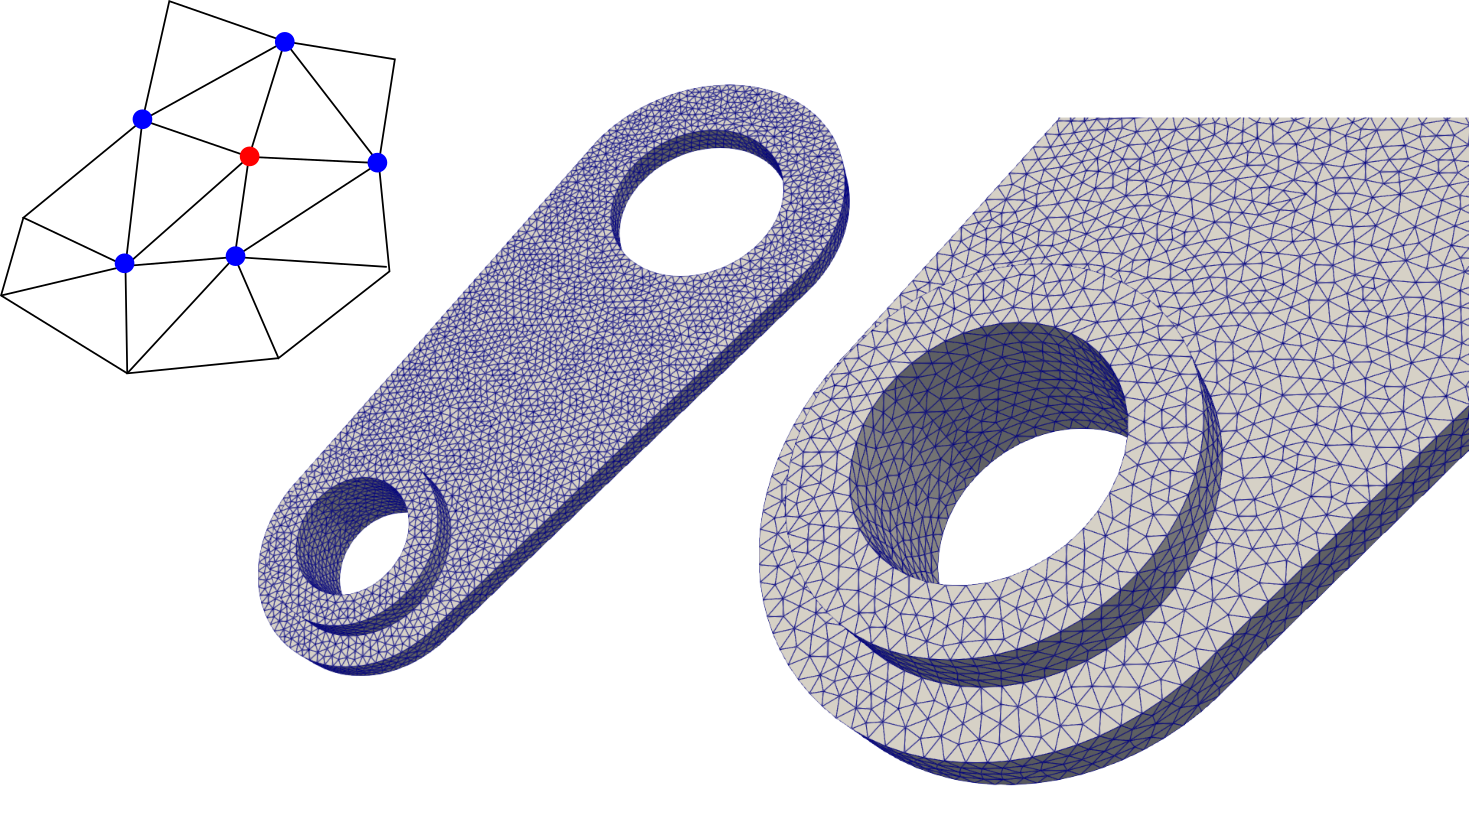
</div>

### k-way graph partitioning problem


Given a graph $G$ (i.e. the mesh)

- Partition the vertices of $G$ into k disjoint parts of equal size (load balance)
- Minimize the number of edges with end vertices belonging to different parts (reduce communication)





### Example

- Partition of a mesh into 8 parts
- Computed with [METIS](https://github.com/KarypisLab/METIS)

<div>
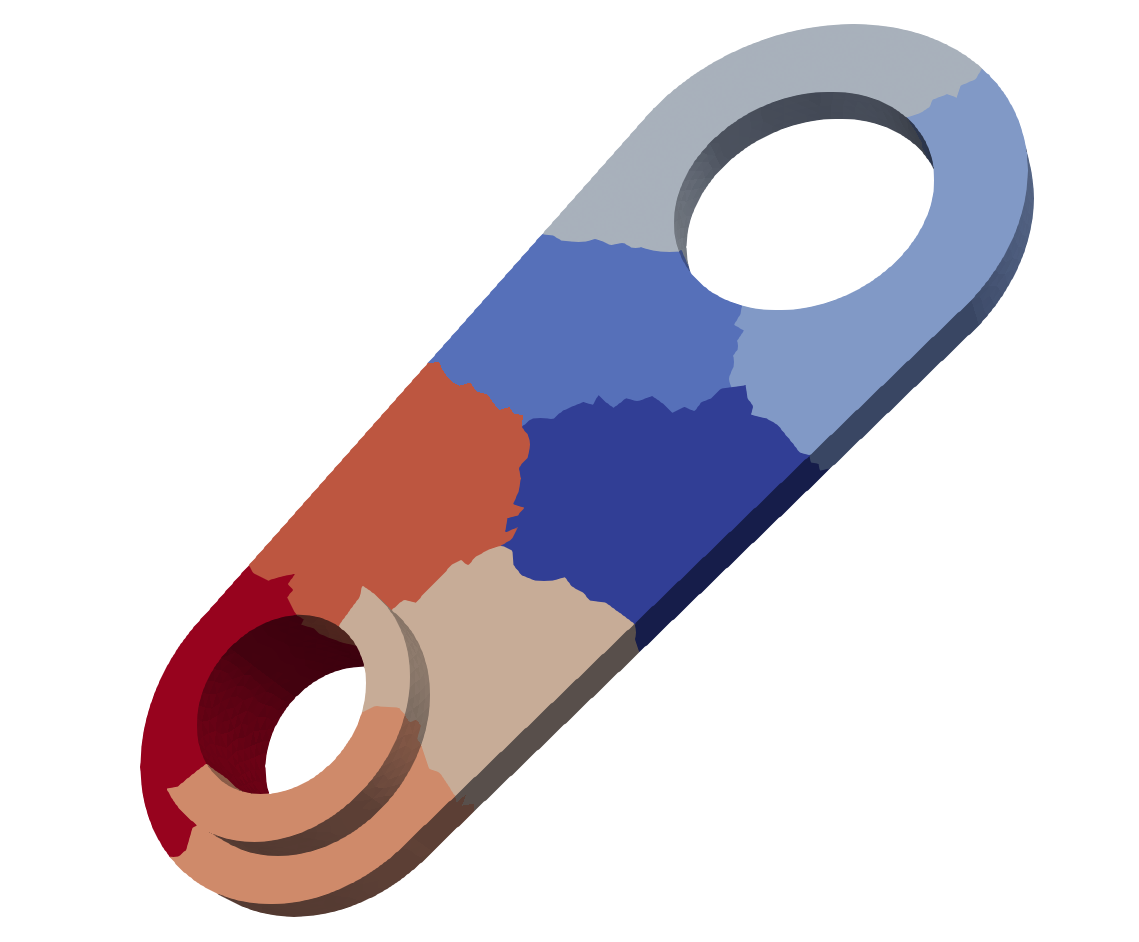
</div>
